In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
sys.path.append("../../")
from neurotools.emg_tools.hd_sEMG import NeuroNexus_H32_tri,HD_sEMG,array_grid,NeuroNexus_H32_tri_interp,interpolate_HD_sEMG
from neurotools.emg_tools.emg_channel import eEMG
from neurotools.ns5_tools.ns5_tools import ns5Files
from neurotools.utils.trigger import trigger as trigger_b
import neurotools.emg_tools.spatial_filtering as sp 

##  Open a file and create an HD_sEMG object

In [2]:
##create or open the EMG arrays
keys = NeuroNexus_H32_tri.required_raw_keys() + ['Tr0 ', 'Tr1 ']

data_file = "./source/test_emg_array.hdf5"
overwrite = True
if not (os.path.isfile(data_file)) or overwrite:
    ns5_path = "./source/UA014_SEL_AS_MS_SGM0_0009.ns5"
    ns5_file = ns5Files(ns5_path)
    if set(keys).issubset(ns5_file.get_analog_entitie_labels()):
        ns5_file.to_hdf(data_file,keys)
    else:
        print("Requested keys not available")
        exit()

df_emg = pd.read_hdf(data_file)
HD_sEMG_no_interp = HD_sEMG(df = df_emg, array = NeuroNexus_H32_tri)   
HD_sEMG_no_interp.filter_eEMGs(f_LPF = 5_000, f_HPF = 30, n_LPF = 5, n_HFP = 5)                        #filter orignal data 
trigger = trigger_b(df_emg['Tr0 '],df_emg['time'])         #add a trigger
HD_sEMG_no_interp.trigger = trigger


## Plot grid

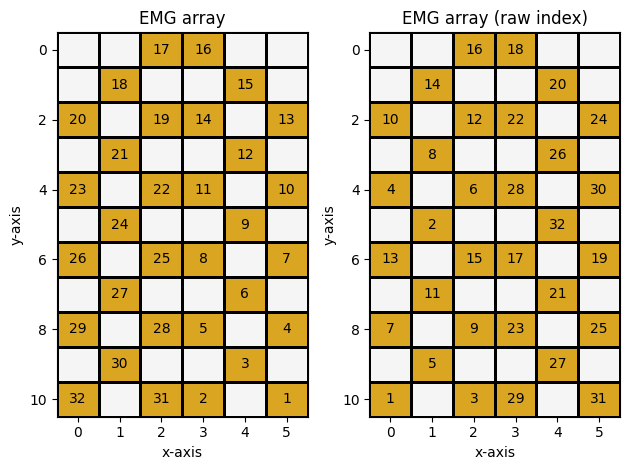

In [3]:
fig, axs = plt.subplots(1,2) 
HD_sEMG_no_interp.array.plot_grid(axs[0], raw_idx=False)
HD_sEMG_no_interp.array.plot_grid(axs[1], raw_idx=True)
fig.tight_layout()

## Creating LSD grid array

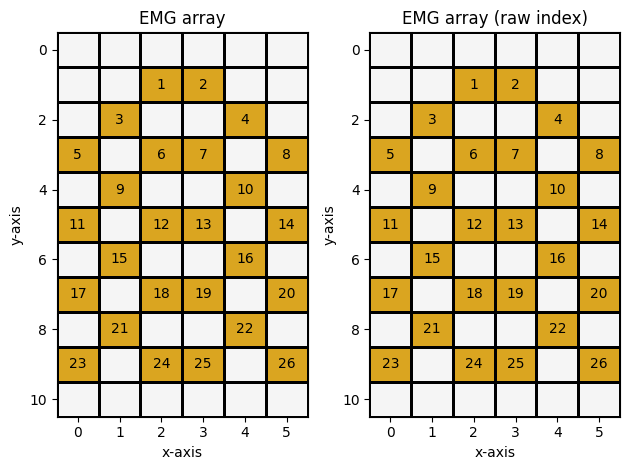

In [4]:
LSD_idx = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                        [np.nan, np.nan, 1, 2, np.nan, np.nan],
                        [np.nan, 3, np.nan, np.nan, 4, np.nan],
                            [5, np.nan, 6, 7, np.nan, 8],
                        [np.nan, 9, np.nan, np.nan, 10, np.nan],
                            [11, np.nan, 12, 13, np.nan, 14],
                        [np.nan, 15, np.nan, np.nan, 16, np.nan],
                            [17, np.nan, 18, 19, np.nan, 20],
                        [np.nan, 21, np.nan, np.nan, 22, np.nan],
                            [23, np.nan, 24, 25, np.nan, 26],
                        [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]])

LSD_2_raw = np.int32(np.nan_to_num(LSD_idx,0))
LSD_2_raw = LSD_2_raw[LSD_2_raw>0].flatten()
LSD_grid = array_grid(elec_to_raw=LSD_2_raw,elec_pos = LSD_idx) 

fig, axs = plt.subplots(1,2) 
LSD_grid.plot_grid(axs[0], raw_idx=False)
LSD_grid.plot_grid(axs[1], raw_idx=True)
fig.tight_layout()

## Matching raw data to SP filter grid data

In [5]:
raw_2_SP = [(19,17),(14,16),(21,18),(12,15),(23,20),(22,19),(11,14),(10,13),(24,21),(9,12),(26,23),(25,22),(8,11),(7,10),
            (27,24),(6,9),(29,26),(28,25),(5,8),(4,7),(30,27),(3,6),(32,29),(31,28),(2,5),(1,4)]

df = pd.DataFrame()
for i,pairs in enumerate(raw_2_SP):
    df[f"raw {i+1}"] = df_emg[HD_sEMG_no_interp.array.get_elect_raw_key(pairs[1])] - df_emg[HD_sEMG_no_interp.array.get_elect_raw_key(pairs[0])] 
df["time"] = HD_sEMG_no_interp.t
HD_sEMG_manual_SP= HD_sEMG(df = df, array = LSD_grid)   

## Validate data

In [6]:
print((HD_sEMG_manual_SP.get_eEMG(9).raw == HD_sEMG_no_interp.get_eEMG(21).raw - HD_sEMG_no_interp.get_eEMG(24).raw).all())
print((HD_sEMG_manual_SP.get_eEMG(24).raw == HD_sEMG_no_interp.get_eEMG(28).raw - HD_sEMG_no_interp.get_eEMG(31).raw).all())
print((HD_sEMG_manual_SP.get_eEMG(2).raw == HD_sEMG_no_interp.get_eEMG(16).raw - HD_sEMG_no_interp.get_eEMG(14).raw).all())
print((HD_sEMG_manual_SP.get_eEMG(17).raw == HD_sEMG_no_interp.get_eEMG(26).raw - HD_sEMG_no_interp.get_eEMG(29).raw).all())

True
True
True
True


## Comparison with interpolated spatial filtering

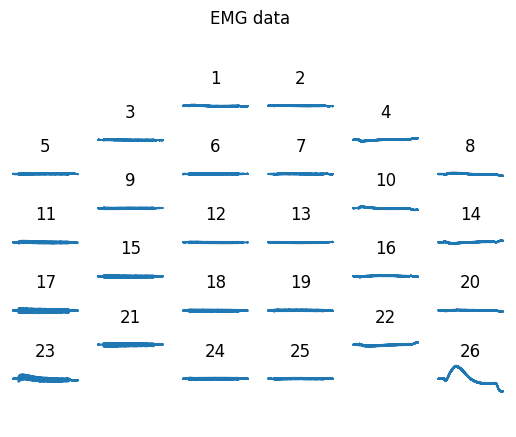

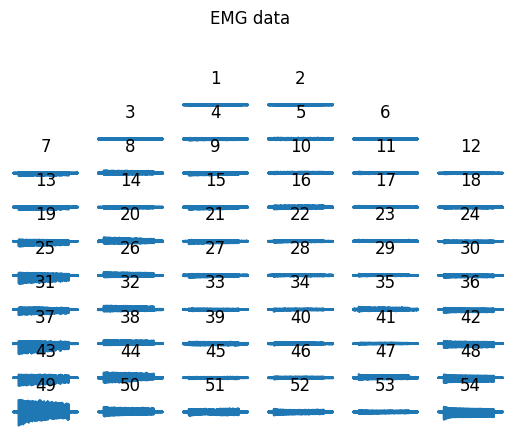

In [ ]:
hd_sEMG_interp = interpolate_HD_sEMG(HD_sEMG_no_interp, NeuroNexus_H32_tri_interp, raw = False)      #interpolate from raw data   
hd_sEMG_interp.trigger = trigger
hd_sEMG_interp.get_eCMAPS(duration = 0.015, delay = 0.001)


hd_semg_LSD = sp.spatial_filter(hd_sEMG_interp,sp.NDD_kernel,raw = False)
#hd_semg_LSD.filter_eEMGs(f_LPF = 5_000, f_HPF = 20, n_LPF = 5, n_HFP = 5)                        #filter orignal data 

HD_sEMG_manual_SP.plot_data()
hd_semg_LSD.plot_data()

print()

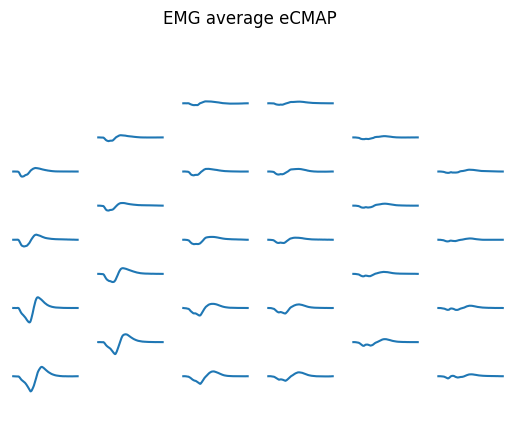

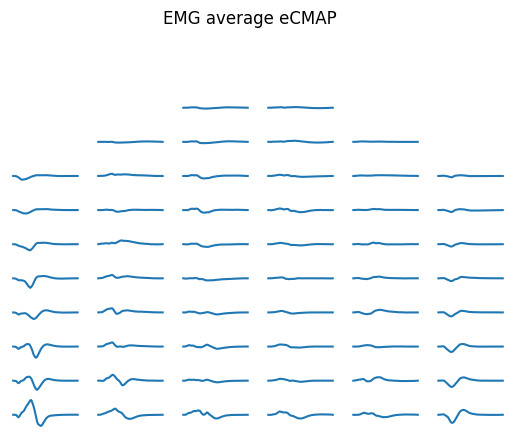

In [8]:
HD_sEMG_manual_SP.trigger = trigger

HD_sEMG_manual_SP.get_eCMAPS(duration = 0.015, delay = 0.001)
HD_sEMG_manual_SP.plot_avg_eCMAP(label=False)

hd_semg_LSD.trigger = trigger

hd_semg_LSD.get_eCMAPS(duration = 0.015, delay = 0.001)
hd_semg_LSD.plot_avg_eCMAP(label=False)
plt.show()

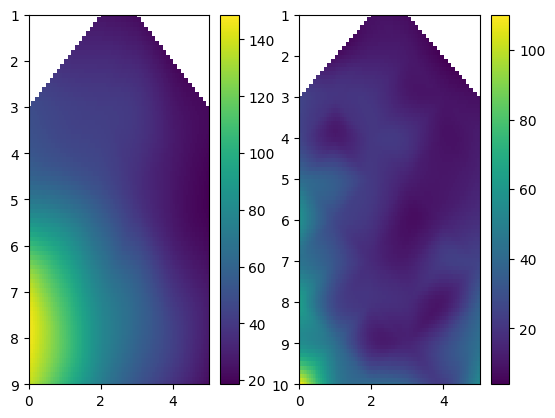

In [9]:

fig, axs = plt.subplots(1,2) 
sc = HD_sEMG_manual_SP.plot_heatmap_eCMAP(axs[0], "rms", n_interp = 100)
fig.colorbar(sc, ax = axs[0])
sc = hd_semg_LSD.plot_heatmap_eCMAP(axs[1], "rms", n_interp = 100)
fig.colorbar(sc, ax = axs[1])


#sc = hd_sEMG_interp.plot_heatmap_eCMAP(axs[2], "rms", n_interp = 100)
#fig.colorbar(sc, ax = axs[2])
#fig.tight_layout()